In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dl_portfolio.data import impute_missing_risk_free, load_data, load_risk_free
from dl_portfolio.backtest import (
    backtest_stats, 
    get_target_vol_other_weights, 
    get_factors_rc_and_weights, 
    get_number_of_nmf_bets,
    get_number_of_pc_bets
)
import pickle
import os
import seaborn as sns
from dl_portfolio.torsion import get_min_torsion_bets


# Some useful functions

In [2]:
def plot_weights(weights, savepath=None, x_step=2):
    strat_to_plot = ['hrp', 'hcaa', 'nmfrp', 'erc', 'rb_factor', 'markowitz', 'GMV_robust']
    nrow, ncol = 2,4
    fig, axs = plt.subplots(nrow, ncol, figsize=(18, 5), sharex=True, sharey=True)
    LABELS = [str(d.date()) for d in weights['hrp'].index]
    NUM_COLORS = len(weights[strat_to_plot[0]].columns)
    cm = plt.get_cmap('gist_rainbow')
    row = -1
    for i, strat in enumerate(strat_to_plot):
        print(strat)
        col = i % ncol
        if col == 0:
            row = row + 1
        print(row, col)
        axs[row, col].set_prop_cycle(color=[cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)])

        """if strat == 'equal_class':
            data = pd.DataFrame(np.repeat(weights['equal_class'].values, len(LABELS), axis=0),
                                columns = weights['hrp'].columns,
                                index = weights['hrp'].index)
        else:
            data = weights[strat]"""

        for j, c in enumerate(list(weights[strat].columns)):
            axs[row, col].bar(LABELS, weights[strat][c], label=c, width=1, align='edge',
                              bottom=weights[strat].iloc[:, :j].sum(1))    
        axs[row, col].tick_params(axis='x', labelrotation=45)
        _ = axs[row, col].set_xticks(list(range(0, len(weights[strat].index), x_step)))

    plt.subplots_adjust(hspace = .1)
    plt.subplots_adjust(wspace = .05)

    if save:
        plt.savefig(savepath, bbox_inches='tight', transparent=True)

def plot_final_backtest_performance(returns, benchmark, save=False, save_path=None, hedge=False):
    plt.figure(figsize=(15,8))
    plt.plot((returns['equal'] + 1).cumprod() - 1, label="equal")
    plt.plot((returns['equal_class'] + 1).cumprod() - 1, label="equal_class")
    plt.plot((returns['markowitz'] + 1).cumprod() - 1, label="markowitz")
    plt.plot((returns['GMV_robust'] + 1).cumprod() - 1, label="GMV_robust")
    
    plt.plot((returns['hrp'] + 1).cumprod() - 1, label="hrp")
    plt.plot((returns['nmfrp'] + 1).cumprod() - 1, label="nmfrp")
    plt.plot((returns['hcaa'] + 1).cumprod() - 1, label="hcaa")
    plt.plot((returns['erc'] + 1).cumprod() - 1, label="erc")
    plt.plot((returns['rb_factor'] + 1).cumprod() - 1, label="nmfrb", color="deepskyblue")
    # plt.plot((returns['rb_factor_erc'] + 1).cumprod() - 1, label="nmfrb_erc")
    
    plt.plot((benchmark.loc[returns.index, 'SP500'] * 0.05 / (benchmark.loc[returns.index, 'SP500'].std() * np.sqrt(252)) + 1).cumprod() - 1, 
             label='SP500', color="navy")
    plt.plot((benchmark.loc[returns.index, 'EuroStoxx50'] * 0.05 / (benchmark.loc[returns.index, 'EuroStoxx50'].std() * np.sqrt(252)) + 1).cumprod() - 1, 
             label='EuroStoxx50', color="royalblue")
    
    plt.plot(returns['rb_factor'] * 0., linestyle= '--', c="lightgrey")
    if save:
        plt.savefig(save_path, bbox_inches='tight', transparent=True)
    else:
        plt.legend()
        plt.show()
        
def load_all_backtest_result(nmf_dir, markowitz_dir, dataset):
    # Load Market budget
    if dataset == 'dataset1':
        market_budget = pd.read_csv('data/dataset1/market_budget_dataset1.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        # market_budget = market_budget.drop('CRIX')
        market_budget['rc'] = market_budget['rc'].astype(int)
    elif dataset == 'dataset2':
        market_budget = pd.read_csv('data/dataset2/market_budget_dataset2.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
        
    # Load markowitz and robust M results
    GMV_robust_weights = pd.read_csv(f"{markowitz_dir}/weights_GMV_robust.csv", index_col = 0)
    GMV_robust_weights.index = pd.to_datetime(GMV_robust_weights.index)
    markowitz_weights = pd.read_csv(f"{markowitz_dir}/weights_MeanVar_long.csv", index_col = 0)
    markowitz_weights.index = pd.to_datetime(markowitz_weights.index)
    
    # Leverage
    leverage = pd.read_csv(f'{nmf_dir}/leverage.csv', index_col = 0)
    pyrobustm, l = get_target_vol_other_weights(f"GMV_robust_{dataset}")
    leverage["GMV_robust"] = l['other']
    pyrobustm.columns = ['GMV_robust']
    markowitz, l = get_target_vol_other_weights(f"MeanVar_{dataset}")
    leverage["markowitz"] = l['other']
    markowitz.columns = ['markowitz']
    
    port_weights = pickle.load(open(f'{nmf_dir}/portfolios_weights.p', 'rb'))
    aekeys = [c for c in port_weights.keys() if "ae" in c]
    for k in aekeys:
        key = k.replace("ae", "nmf")
        port_weights[key] = port_weights[k]
        port_weights.pop(k)
        
    port_weights["markowitz"] = markowitz_weights.loc[port_weights["rb_factor"].index]
    port_weights["GMV_robust"] = GMV_robust_weights.loc[port_weights["rb_factor"].index]


    ann_perf = pd.read_csv(f'{nmf_dir}/portfolios_returns.csv', index_col = 0, parse_dates=True)
    ann_perf['GMV_robust'] = pyrobustm['GMV_robust']
    ann_perf['markowitz'] = markowitz['markowitz']
    
    ann_perf.columns = [c.replace('ae', 'nmf') for c in ann_perf.columns]
    stats = backtest_stats(ann_perf, port_weights, period=250, market_budget=market_budget,
                           prices=load_data(dataset)[0])
    
    # Get number of bets
    cv_results = pd.read_pickle(f"{nmf_dir}/cv_results.p")
    for i in cv_results:
        for cv in cv_results[i]:
            cv_results[i][cv]["port"]["markowitz"] = port_weights["markowitz"].iloc[cv]
            cv_results[i][cv]["port"]["GMV_robust"] = port_weights["GMV_robust"].iloc[cv]        
    risk_contribution, factor_weights = get_factors_rc_and_weights(
                cv_results,
                market_budget.drop("CRIX") if dataset == "dataset1"  else market_budget
            )
    number_bets = get_number_of_nmf_bets(risk_contribution)
    stats["NMF Bets"] = np.mean(number_bets).rename({"aerp": "nmfrp"})

    
    rcs_a, n_bets_a = get_min_torsion_bets(cv_results,
                                           market_budget.drop("CRIX") if dataset == "dataset1"  else market_budget,
                                           level="asset")
    stats["MT Bets"] = np.mean(n_bets_a).rename({"aerp": "nmfrp"})
    
    rcs_f, n_bets_f = get_min_torsion_bets(cv_results,
                                           market_budget.drop("CRIX") if dataset == "dataset1"  else market_budget,
                                           level="factor")
    stats["MT Bets_F"] = np.mean(n_bets_f).rename({"aerp": "nmfrp"})


    return ann_perf, port_weights, leverage, stats


# Save directory

In [3]:
SAVE=True
save=SAVE
savedir = "paper_result_update/nmf"
if save:
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
   

# Load backtest result

In [4]:
perf_nmf_dir_1 = "./performance/test_final_models/nmf/dataset1_20230417_123807"
markowitz_dir1 = "final_models/run_11_dataset1_20230408_145352"
perf_nmf_dir_2 = "./performance/test_final_models/nmf/dataset2_20230417_123835"
markowitz_dir2 = "final_models/run_12_dataset2_20230408_145946"

perf1, port_weights1, leverage1, stats1 = load_all_backtest_result(perf_nmf_dir_1,
                                                                   markowitz_dir1,
                                                                   "dataset1")
dates1 = perf1.index

perf2, port_weights2, leverage2, stats2 = load_all_backtest_result(perf_nmf_dir_2,
                                                                   markowitz_dir2,
                                                                   "dataset2")
dates2 = perf2.index

[DL-Portfolio-Logger:backtest.py:177] - [9956] - 2023-04-17 12:49:11,779 - DEBUG - Formatting table
[DL-Portfolio-Logger:backtest.py:177] - [9956] - 2023-04-17 12:49:47,197 - DEBUG - Formatting table
/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
benchmark  = pd.read_csv("data/benchmarks.csv", index_col=0, parse_dates=True)
benchmark = benchmark.pct_change().dropna()

risk_free = load_risk_free()
risk_free = risk_free.reindex(benchmark.index)
risk_free = impute_missing_risk_free(risk_free)

benchmark1 = benchmark.reindex(dates1)
benchmark2 = benchmark.reindex(dates2)

leverage1 = 0.05 / (benchmark1.std() * np.sqrt(252))
lev_cost = np.repeat(risk_free.reindex(benchmark1.index).values,
                     len(leverage1), axis=-1) * (1 - leverage1.values.reshape(1,-1))
benchmark1 = benchmark1*leverage1 + lev_cost

leverage2 = 0.05 / (benchmark2.std() * np.sqrt(252))
lev_cost = np.repeat(risk_free.reindex(benchmark2.index).values, 
                     len(leverage2), axis=-1) * (1 - leverage2.values.reshape(1,-1))
benchmark2 = benchmark2*leverage2 + lev_cost



# Dataset 1

## Backtest performance

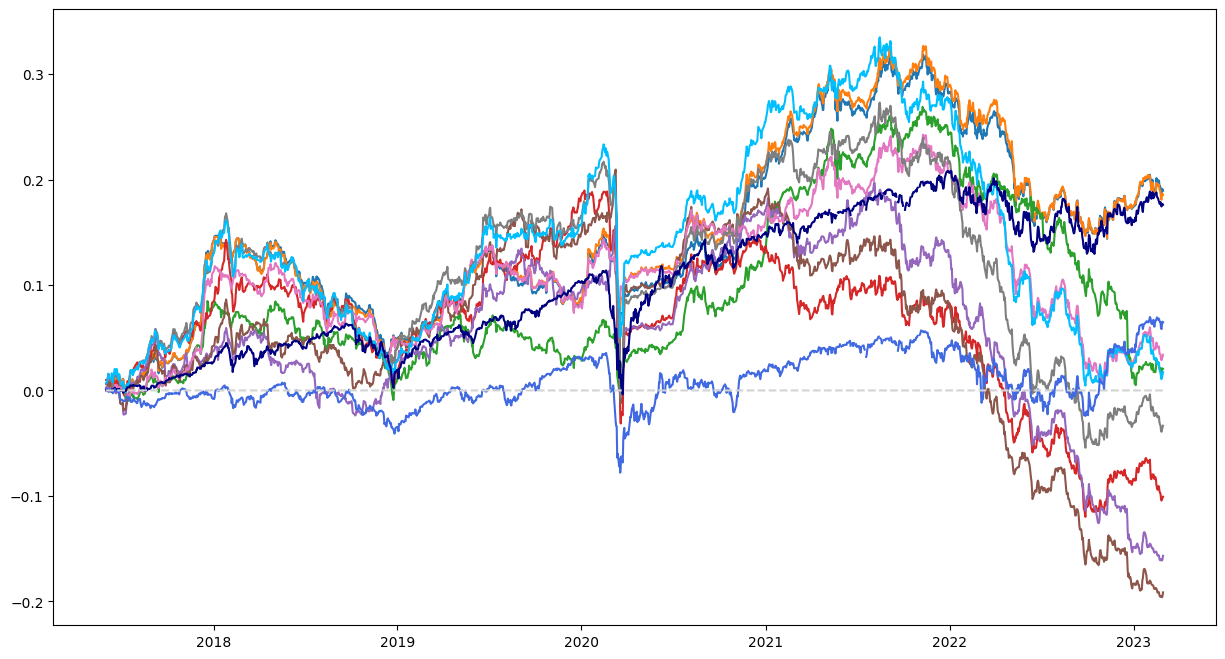

In [6]:
save = SAVE
save_path = f"{savedir}/performance_all_dataset1.png"
plot_final_backtest_performance(perf1, benchmark1, save=save, save_path=save_path)


## Backtest stats

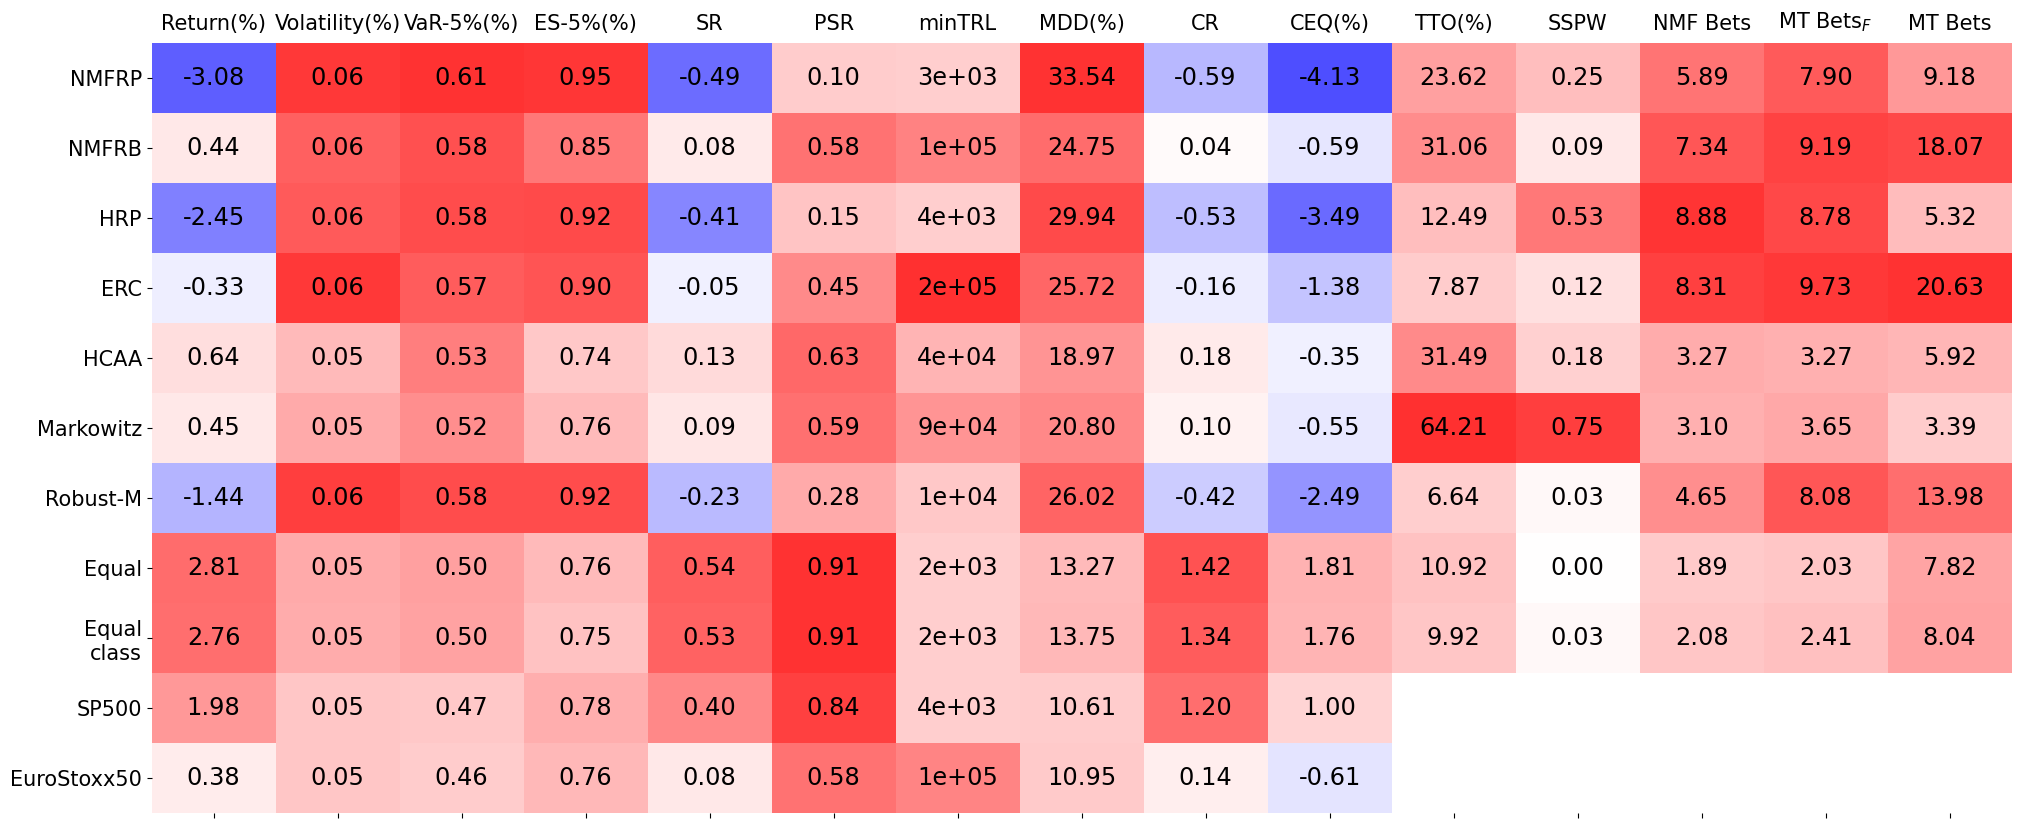

In [15]:
save = SAVE
ORDER = [ "nmfrp", "rb_factor", "hrp", "erc", "hcaa", "markowitz", "GMV_robust",
         "equal", "equal_class", "SP500", "EuroStoxx50"]

YTICKLABELS = ["NMFRP", "NMFRB", "HRP", "ERC",
               "HCAA",  "Markowitz", "Robust-M", 
               "Equal", "Equal\nclass", "SP500", "EuroStoxx50"]
stats1.loc[['SP500', 'EuroStoxx50'], 'TTO'] = np.nan
METRICS_ORDER = [
 'Return',
 'Volatility',
 'VaR-5%',
 'ES-5%',
 'SR',
 'PSR',
 'minTRL',
 'MDD',
 'CR',
 'CEQ',
 'TTO',
 'SSPW',
 'NMF Bets',
 'MT Bets_F',
 'MT Bets'
]
pstats = stats1.loc[ORDER, METRICS_ORDER]

metrics = [c for c in list(pstats.columns) if c not in ['Skewness', 'Excess kurtosis']]
fig, axs = plt.subplots(1, len(metrics), figsize = (24,10))
i = 0
for i, c in enumerate(metrics):
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        xticklabel = c + '(%)'
    else:
        xticklabel = c
    if c == "MT Bets_F":
        xticklabel = "$\operatorname{MT\ Bets}_F$"
    temp = pstats[[c]] 
    min_ = min(temp[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp[c]) - np.std(temp[c])
    sns.heatmap(np.abs(temp) if c == "SSPW" else temp,
                cmap='bwr', 
                center=center,
                vmin=min(temp[c]) - np.std(temp[c]),
                vmax=max(temp[c]) + np.std(temp[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [xticklabel],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_dataset1.png', bbox_inches='tight', transparent=True)
   
    

## Weights

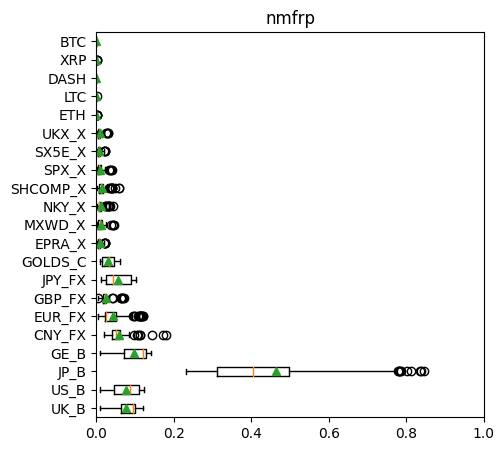

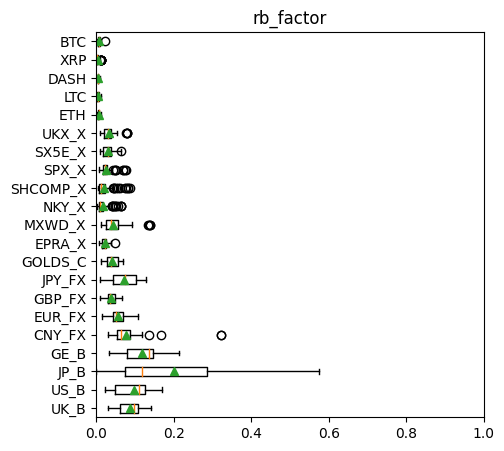

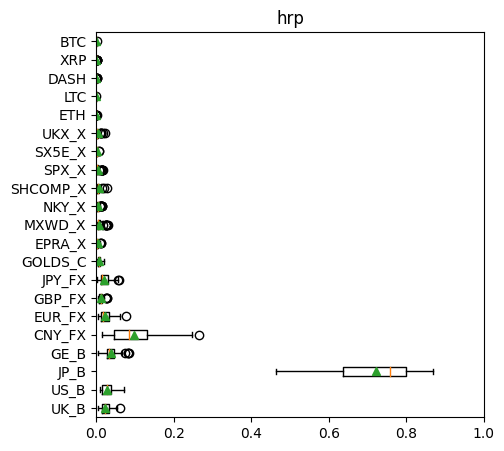

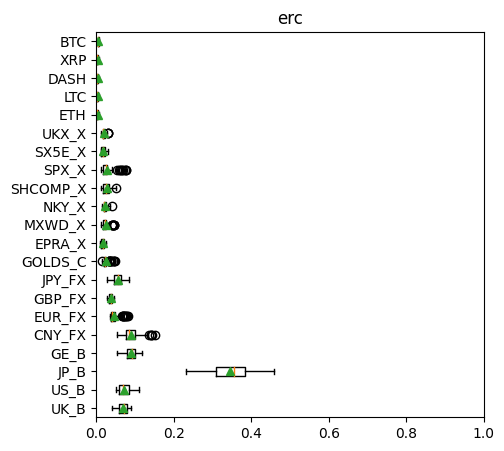

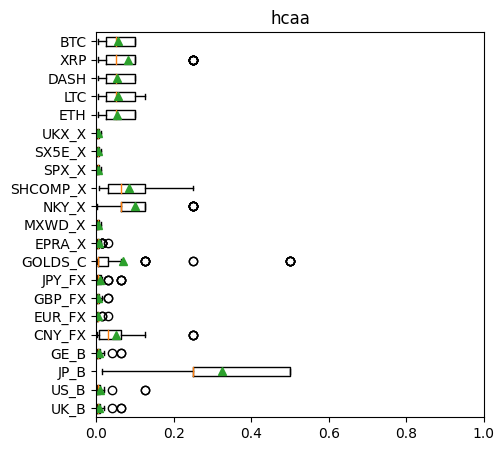

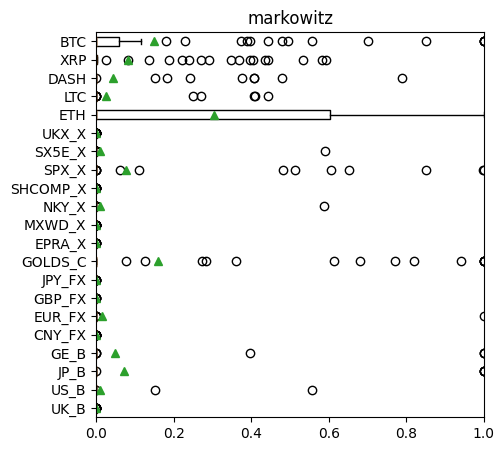

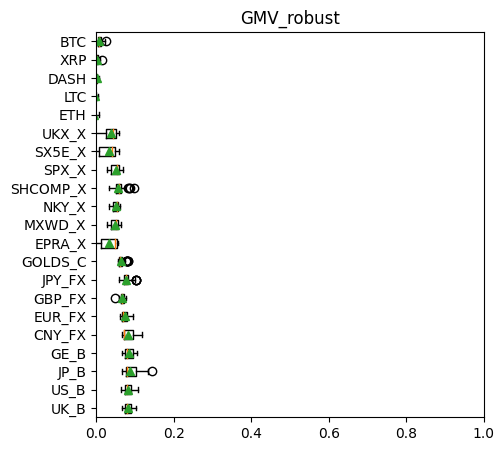

In [22]:
save=SAVE
weights_to_plot = ["nmfrp", "rb_factor", "hrp", "erc", "hcaa", "markowitz", "GMV_robust"]
for p in weights_to_plot:
    fig = plt.figure(figsize=(5,5))
    assets = port_weights1[p].columns.tolist()
    plt.boxplot(port_weights1[p].T, showmeans=True, vert=False)
    plt.yticks(range(1, len(assets)+1), assets)
    plt.xlim(0., 1)
    if save:
        plt.savefig(f"{savedir}/weights_{p}_1.png", transparent=True, bbox_inches="tight")
    plt.title(p)
    plt.show()

# Dataset 2
## Backtest performance

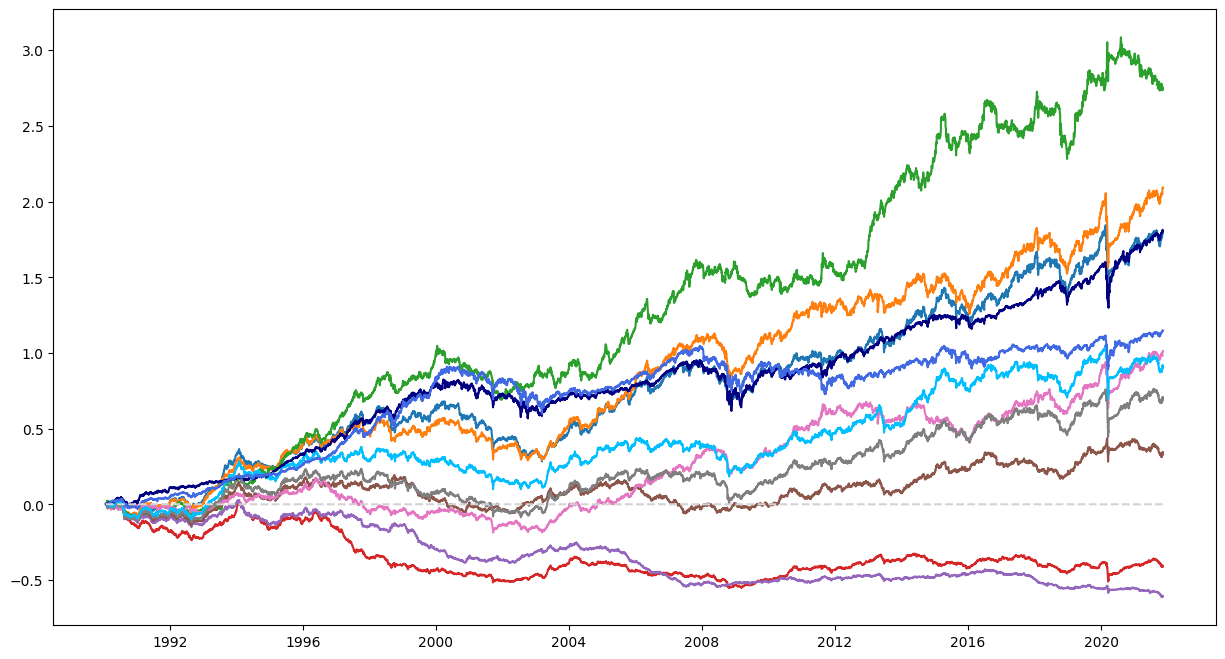

In [8]:
save = SAVE
save_path = f"{savedir}/performance_all_dataset2.png"
plot_final_backtest_performance(perf2, benchmark2, save=save, save_path=save_path)


## Backtest stats

In [9]:
stats2

,Return,Volatility,Skewness,Excess kurtosis,VaR-5%,ES-5%,SR,PSR,minTRL,MDD,CR,CEQ,SSPW,TTO,NMF Bets,MT Bets,MT Bets_F
equal,3.393989,0.053609,-0.714706,3.635745,0.520509,0.811017,0.633097,0.999771,1742.674438,23.631868,7.557346,1.530810,0.000000,2.725236,2.922493,11.236902,2.939270
equal_class,3.708642,0.053113,-0.700495,4.050810,0.510092,0.789129,0.698255,0.999943,1437.323120,17.888977,11.611112,1.848112,0.028150,2.769524,3.685764,10.483507,3.828139
hrp,-2.831268,0.053508,-0.146373,2.560585,0.544649,0.795041,-0.529134,0.001442,2410.093750,62.498219,-0.975537,-4.693902,0.382100,9.301298,3.804359,8.263824,4.686497
hcaa,2.356351,0.053619,-0.696667,5.850125,0.524339,0.798725,0.439464,0.992765,3578.409180,30.814611,3.272873,0.493122,0.138322,20.365030,3.571016,5.513380,3.906174
nmfrp,1.042102,0.052542,-0.253278,0.745952,0.531230,0.756772,0.198335,0.867258,17254.201172,21.408890,1.539321,-0.815414,0.171086,8.806237,3.263667,10.393759,3.915267
erc,1.819363,0.055513,-0.751084,6.550666,0.537448,0.819897,0.327734,0.966213,6404.115234,25.920984,2.659842,-0.054205,0.107724,4.634885,4.787258,16.659259,5.414357
rb_factor,2.184258,0.054586,-0.730219,6.383804,0.542098,0.807704,0.400149,0.987056,4311.023438,20.263592,4.425683,0.315795,0.101525,10.802749,4.967596,14.590006,5.570799
rb_factor_full_erc,1.916752,0.054819,-0.721998,6.200951,0.538798,0.810840,0.349653,0.974387,5629.379883,22.859846,3.245496,0.047017,0.103763,10.303032,5.187241,14.722040,5.703394
GMV_robust,-1.503939,0.058284,-0.634834,7.875763,0.578641,0.854939,-0.258037,0.072405,10063.015625,56.441055,-0.730736,-3.393271,0.111043,8.475641,8.086640,10.434420,8.943364
markowitz,4.337754,0.055904,-0.280495,2.770734,0.546720,0.825001,0.775932,0.999992,1145.154053,17.368689,15.769093,2.462012,0.954672,57.383831,2.509883,3.086124,3.044489


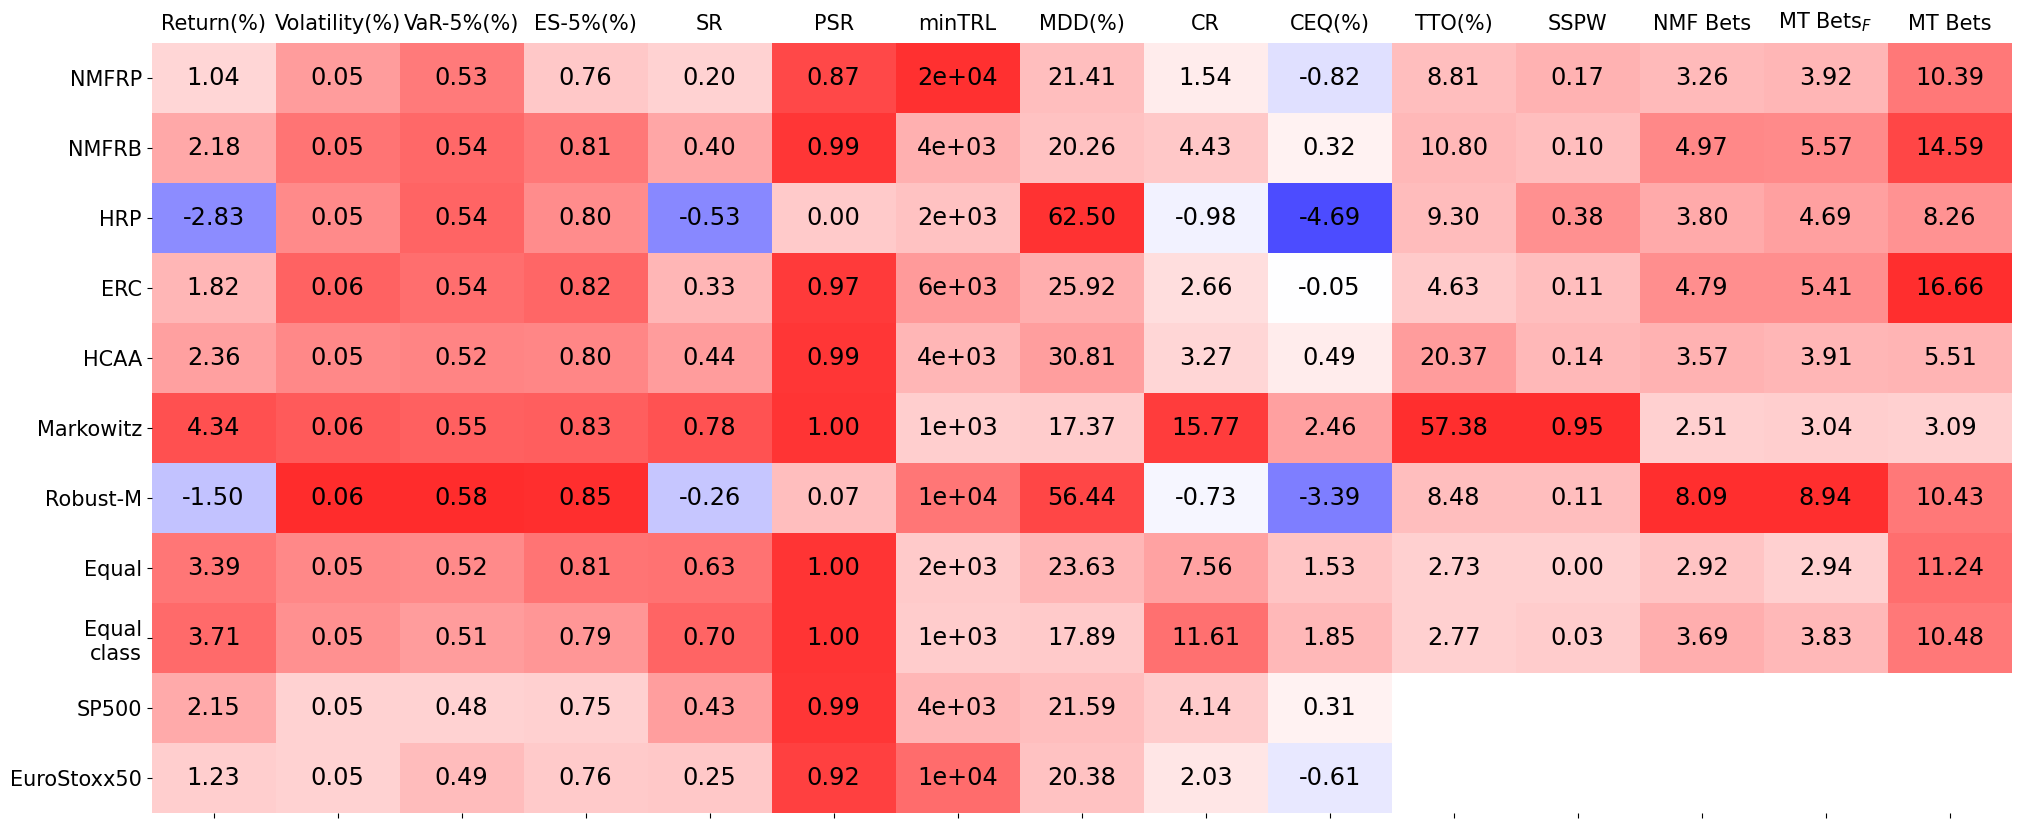

In [16]:
save = SAVE
stats2.loc[['SP500', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats2.loc[ORDER, METRICS_ORDER]

metrics = [c for c in list(pstats.columns) if c not in ['Skewness', 'Excess kurtosis']]
fig, axs = plt.subplots(1, len(metrics), figsize = (24,10))
i = 0
for i, c in enumerate(metrics):
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        xticklabel = c + '(%)'
    else:
        xticklabel = c
        
    if c == "MT Bets_F":
        xticklabel = "$\operatorname{MT\ Bets}_F$"
        
    temp = pstats[[c]] 
    min_ = min(temp[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp[c]) - np.std(temp[c])
    sns.heatmap(np.abs(temp) if c == "SSPW" else temp,
                cmap='bwr', 
                center=center,
                vmin=min(temp[c]) - np.std(temp[c]),
                vmax=max(temp[c]) + np.std(temp[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [xticklabel],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)

plt.subplots_adjust(wspace=0., hspace=0.)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_dataset2.png', bbox_inches='tight', transparent=True)
   
    

## Weights

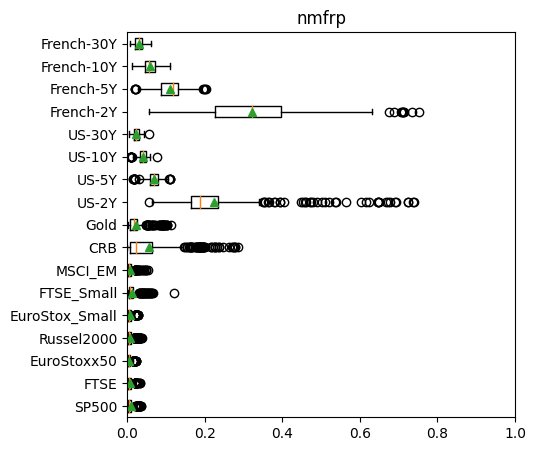

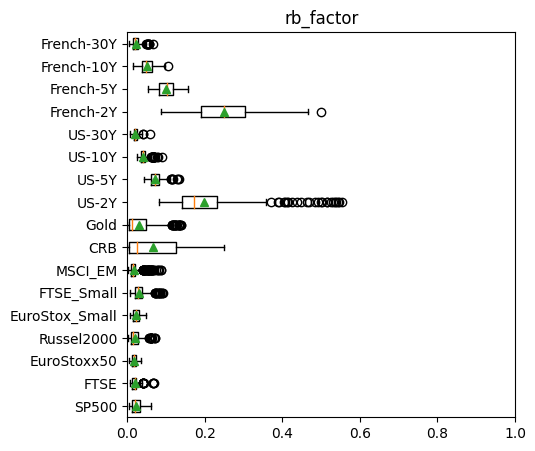

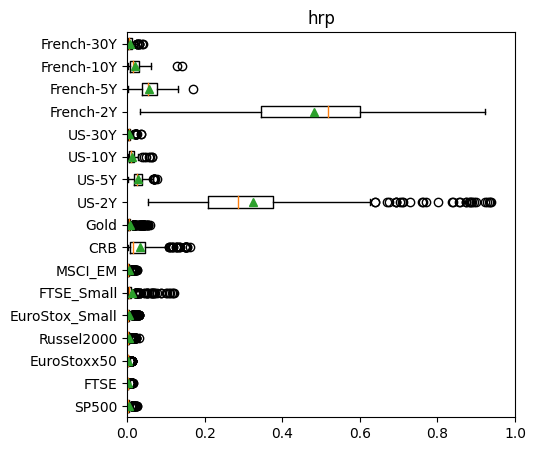

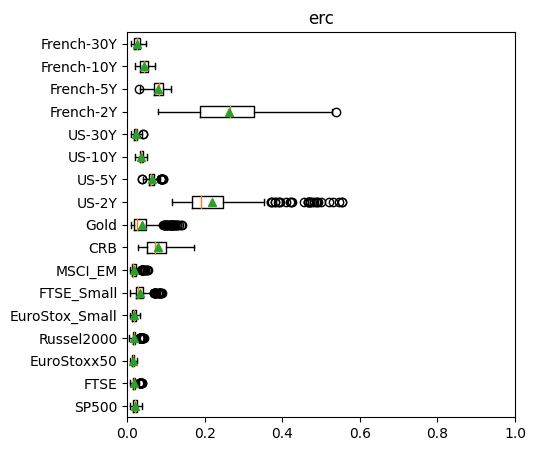

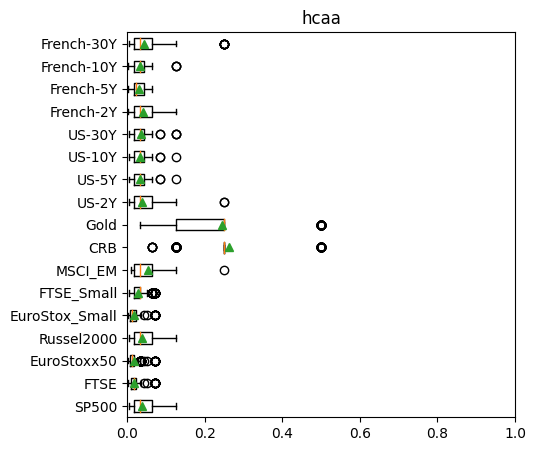

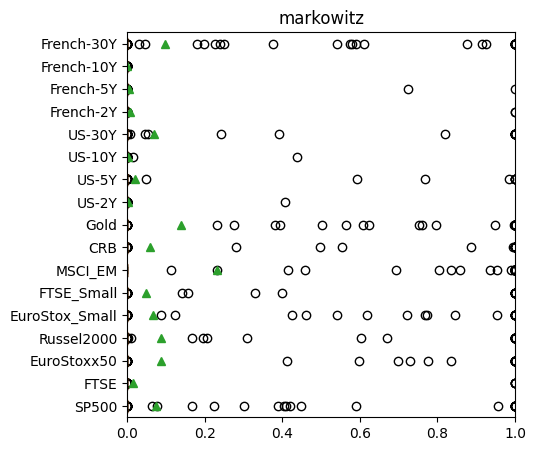

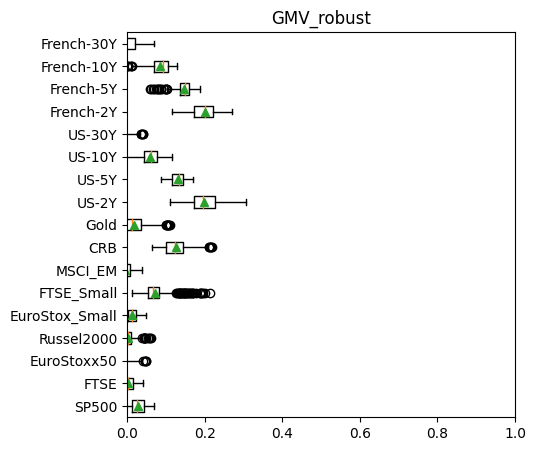

In [21]:
save=SAVE
for p in weights_to_plot:
    fig = plt.figure(figsize=(5,5))
    assets = port_weights2[p].columns.tolist()
    plt.boxplot(port_weights2[p].T, showmeans=True, vert=False)
    plt.yticks(range(1, len(assets)+1), assets)
    plt.xlim(0., 1)
    if save:
        plt.savefig(f"{savedir}/weights_{p}_2.png", transparent=True, bbox_inches="tight")
    plt.title(p)
    plt.show()